# Deep Learning Medical Image Analysis PneumoniaMNIST Part 3

Source For Codes

1.https://colab.research.google.com/drive/1LRlehId853iY2QytjFdZJuNb4mJfdNoY?usp=sharing

2.https://machinelearningknowledge.ai/keras-dense-layer-explained-for-beginners/

3.https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

## Python Imports


In [ ]:
# Built-in Imports
import random

In [ ]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Downloader


In [ ]:
DATA_NAME = "PneumoniaMNIST"

In [ ]:
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2023-04-01 10:24:29--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22841 (22K) [text/plain]
Saving to: ‘info.py.2’

info.py.2           100%[===================>]  22.31K  --.-KB/s    in 0.001s  

2023-04-01 10:24:29 (35.8 MB/s) - ‘info.py.2’ saved [22841/22841]



In [ ]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz", 
                     origin=data["url"], 
                     md5_hash=data["MD5"])

In [ ]:
# Loads the downloaded NumPy object.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_y = dataset["train_labels"]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_y = dataset["val_labels"]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_y = dataset["test_labels"]

## Data Exploration


In [ ]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]), 
                            np.append(val_counts, [sum(val_counts)]), 
                            np.append(test_counts, [sum(test_counts)]))), 
                   index=labels, columns=["Train", "Val", "Test"]))

           Train  Val  Test
normal      1214  135   234
pneumonia   3494  389   390
total       4708  524   624


2595: pneumonia


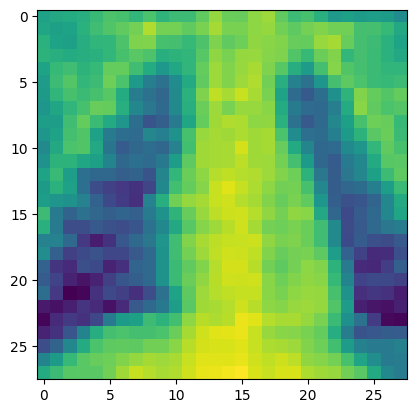

In [ ]:
# Displays a random image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[random.randint(0, len(train_x))])

## Data Processing

Data Augmentation was used to incresed the dataset. This was done by multiple methods.

Images were randomly rotated by 20 degrees

Shifts of image vertically and horizontally

Changing shear(distortion amount) value

Flip of the image both vertically and horizontally.

This step was done to reduce the chance of overfitting.

In [ ]:
data_generator2 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

In [ ]:
# Defines the data generator that will be used to augment the images as they are loaded.
#data_generator = ImageDataGenerator(featurewise_center=True,
                                    #featurewise_std_normalization=True,
                                    #horizontal_flip=True, 
                                    #vertical_flip=True)

In [ ]:
print(train_x.shape)
print(val_x.shape)

(4708, 28, 28)
(524, 28, 28)


In [ ]:
#reshaped to rank 4
train_x = train_x.reshape((4708, 28, 28, 1))
val_x = val_x.reshape((524, 28, 28, 1))


In [ ]:
data_generator2.fit(np.append(train_x, val_x, 0))

## Model Definition

Model architecture was defined 3 convolutionary layers with increased filter value so that model will capture more details patterns of input images when training.

Dropout was used as the regularization as it reduces the complexities during training than other regularizers.

Model architecture was finalized based on model performance. Number of layers, filter value, Batch size, number of epochs: These features were used with different value combination to find a good model.

In [ ]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the first convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)
dropout_1 = layers.Dropout(0.25)(pool_1)

# Defines the second convolutional layer with max pooling.
conv_2 = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)
dropout_2 = layers.Dropout(0.25)(pool_2)

# Defines the third convolutional layer with max pooling.
conv_3 = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(dropout_2)
pool_3 = layers.MaxPool2D(pool_size=(2, 2))(conv_3)
dropout_3 = layers.Dropout(0.25)(pool_3)

# Flattens the outputs of the convolutoonal layers into a one dimensional array.
flatten = layers.Flatten()(pool_3)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=len(np.unique(train_y)), activation="softmax")(flatten)

# Initilises the defined model and prints summary of the model.
model = Model(inputs=input, outputs=output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 5, 5, 128)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 5, 5, 128)         0     

## Model Training


In [ ]:
# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 200
LEARNING_RATE = 0.001

In [ ]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# We use the data generator to pass the training and validation data to the model to train it.
history = model.fit(data_generator2.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE), 
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator2.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/200
73/73 [==============================] - 4s 42ms/step - loss: 0.9309 - accuracy: 0.7458 - val_loss: 0.4534 - val_accuracy: 0.8111
Epoch 2/200
73/73 [==============================] - 2s 27ms/step - loss: 0.4331 - accuracy: 0.8118 - val_loss: 0.3913 - val_accuracy: 0.8435
Epoch 3/200
73/73 [==============================] - 2s 28ms/step - loss: 0.4234 - accuracy: 0.8158 - val_loss: 0.3878 - val_accuracy: 0.8111
Epoch 4/200
73/73 [==============================] - 2s 27ms/step - loss: 0.4215 - accuracy: 0.8175 - val_loss: 0.3818 - val_accuracy: 0.8073
Epoch 5/200
73/73 [==============================] - 2s 28ms/step - loss: 0.3854 - accuracy: 0.8299 - val_loss: 0.3825 - val_accuracy: 0.8130
Epoch 6/200
73/73 [==============================] - 3s 34ms/step - loss: 0.3937 - accuracy: 0.8275 - val_loss: 0.3657 - val_accuracy: 0.8321
Epoch 7/200
73/73 [==============================] - 2s 33ms/step - loss: 0.3862 - accuracy: 0.8352 - val_loss: 0.3988 - val_accuracy: 0.8244
Epoch 

##Test Data

Checking Accuracy on test Data

In [ ]:
#Predicting values for test data using the model
model.predict(test_x)

20/20 [==============================] - 0s 2ms/step


array([[4.79522336e-04, 9.99520540e-01],
       [1.51036610e-03, 9.98489618e-01],
       [8.27866256e-01, 1.72133744e-01],
       ...,
       [8.84779155e-01, 1.15220815e-01],
       [3.92313361e-01, 6.07686579e-01],
       [9.98460412e-01, 1.53960951e-03]], dtype=float32)

In [ ]:
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [ ]:
#Converting test labels into model prediction output shape to compare
test_y = tf.keras.utils.to_categorical(test_y, num_classes=2)

In [ ]:
model.evaluate(test_x,test_y)

20/20 [==============================] - 0s 3ms/step - loss: 0.2610 - accuracy: 0.8990


[0.26101499795913696, 0.8990384340286255]

## Plot Learning Curves
This is where we visualise the training of the model.

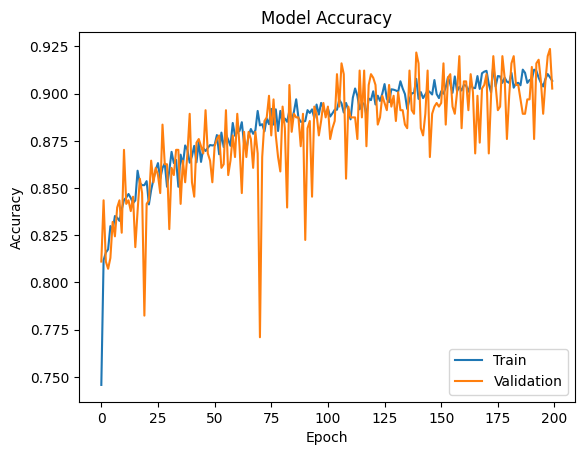

In [ ]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

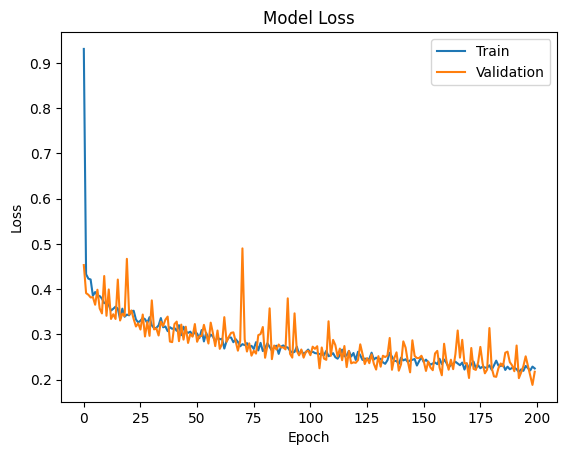

In [ ]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

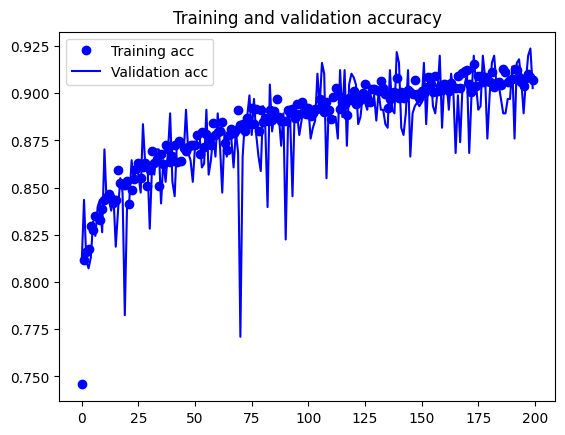

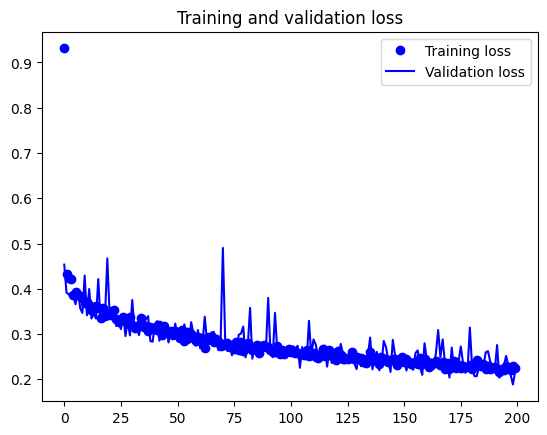

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Discussion

Loss function was change to binary crossentropy(to predict the difference of actual binary and predicted distributions) as this is a binary classification task

Input layer identifies shape of input using train_x.

Above graph on accuracy shows that while training the model, accuracy increses over training epochs.

Loss graph shows while training the model loss gradually decreses.

Accuracy of the model in training phase is 0.90 and loss is 0.22.

Accuracy and Loss values on test data

loss: 0.26 accuracy: 0.89

Below table shows comparsion of other model performance.

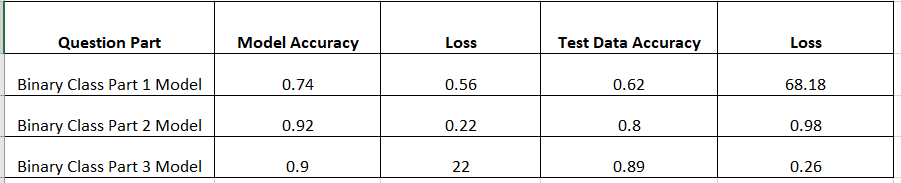

Table shows that out of 3 models third model performed best. It has a accuracy of 0.89, highest from all and very low loss of 0.22.

**Time Duration**

30 hours of work has been done on completing the assignment